Прежде чем запускать следующее, нужно пройти VK-авторизацию!

In [445]:
import numpy as np
import pandas as pd
import matplotlib
from collections import defaultdict
from matplotlib import pyplot as plt
from urllib import urlencode

import urllib2
import time
import json
import operator
import urllib2 

In [446]:
file = open('datasets/token', 'r')
accessToken = file.read()

# Достаем участников групп

In [288]:
groups = ["109490789", 
          "2100831", 
          "11912933", 
          "1167943", 
          "15335079", 
          "12813079", 
          "68478644",
          "16vzvoduvo",
          "59565067",
          "61511779",
          "1182973",
          "1119648",
          "21754234",
          "14294712",
          "7591998",
          "8702762",
          "23386497",
          "1566321",
          "55523638"]

users = []

for group in groups:
    params = {"group_id": group, 
              "count": 500, 
              "fields": "sex,education,universities,schools",
              "access_token": accessToken}
    params = urlencode(params)

    url = "https://api.vk.com/method/groups.getMembers?" + params
    data = json.load(urllib2.urlopen(url))
    data_users = data['response']['users']
    
    print("extracted %d users from %s" % (len(data_users), group))
    users.extend(data_users)
    time.sleep(0.5)
    
print("sum: %d" % len(users))

f = open('datasets/policeGroups/users.json','w')
f.write(json.dumps(users))
f.close()

extracted 26 users from 109490789
extracted 326 users from 2100831
extracted 51 users from 11912933
extracted 104 users from 1167943
extracted 41 users from 15335079
extracted 31 users from 12813079
extracted 17 users from 68478644
extracted 13 users from 16vzvoduvo
extracted 97 users from 59565067
extracted 30 users from 61511779
extracted 341 users from 1182973
extracted 233 users from 1119648
extracted 91 users from 21754234
extracted 8 users from 14294712
extracted 35 users from 7591998
extracted 34 users from 8702762
extracted 2 users from 23386497
extracted 86 users from 1566321
extracted 44 users from 55523638
sum: 1610


# Университеты полицейских

In [ ]:
%matplotlib inline

with open('datasets/policeGroups/users.json') as data_file:    
    users = json.load(data_file)

df = pd.DataFrame(users)
df = df.groupby('university_name').size()

df.sort(['university_name'], ascending=False)
df = df.drop(df.index[[0]])
plt.figure(figsize=(15, 20))
plt.xkcd()

matplotlib.rc('xtick', labelsize=0)
matplotlib.rc('ytick', labelsize=20)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off') # labels along the bottom edge are off

p = df[:15].plot(kind='barh', color='#555577')
p.set_xlabel("")
p.set_ylabel("")
p.get_figure().set_size_inches(20, 12)
p.get_figure().tight_layout()
p.get_figure().savefig('images/universities_police_all.png', dpi=100)

# Пол полицейских

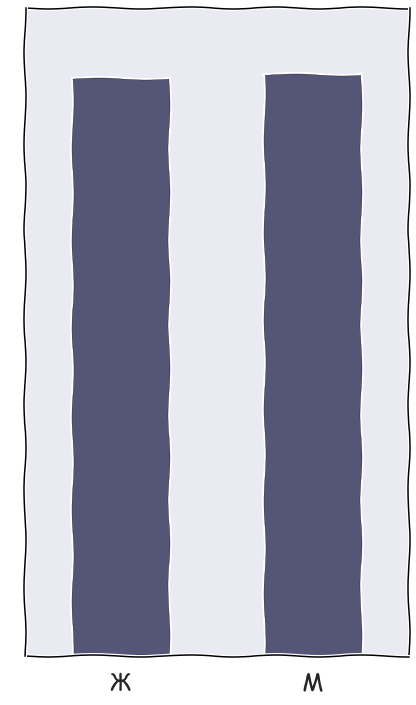

In [451]:
%matplotlib inline

with open('datasets/randomPeople/users.json') as data_file:    
    users = json.load(data_file)

def update_sex(user):
    user['sex_name'] = {
        0: 'N/A',
        1: u'Ж',
        2: u'М',
    }[user['sex']]
    return user

users = map(update_sex, users)
users = filter(lambda x: x['sex'] != 0, users)
    
df = pd.DataFrame(users)
df = df.groupby('sex_name').size()

p = df.plot(kind='bar', color='#555577')

plt.xkcd()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',
    bottom='off')         # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',
    right='off')         # labels along the bottom edge are off

matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=0)

plt.xticks(rotation=0)

p.set_xlabel("")
p.get_figure().set_size_inches(6, 10)
p.get_figure().tight_layout()
p.get_figure().savefig('images/sex_all.png', dpi=100)

# Группы полицейских
Загружаем и кладем в файл

In [ ]:
with open('datasets/randomPeople/users.json') as data_file:    
    users = json.load(data_file)

groups = {}

print("processing %d users" % len(users))
for i in range(0, len(users)):
    params = {"user_id": users[i]['uid'], 
              "extended": 0, 
              "access_token": accessToken}
    params = urlencode(params)

    url = "https://api.vk.com/method/groups.get?" + params
    data = json.load(urllib2.urlopen(url))
    
    if data.get('response', ''):
        user_groups = data['response']
        for user_group in user_groups:
            groups[user_group] = groups.get(user_group, 0) + 1

        print "%d" % (i + 1),
    time.sleep(0.5)
    
f = open('datasets/randomPeople/groups_ids.json','w')
f.write(json.dumps(groups))
f.close()

 processing 2503 users
1 5 7 9 10 13 14 18 20 21 22 23 24 25 28 33 37 38 41 42 43 44 46 48 49 50 51 54 56 57 58 59 60 65 68 70 71 72 73 76 77 80 82 83 85 86 90 91 94 95 97 98 99 100 101 105 106 107 109 110 111 112 113 114 115 116 119 120 121 122 123 124 125 126 128 130 132 133 134 136 137 138 139 141 143 145 147 148 149 150 151 152 153 155 156 157 158 160 162 164 165 166 167 168 171 173 176 178 179 180 184 185 186 188 189 190 191 193 194 196 198 200 201 203 205 206 208 209 210 213 214 216 217 221 222 225 226 228 230 233 234 235 236 239 240 241 242 244 245 246 252 254 255 257 258 259 260 261 262 263 266 267 268 269 270 271 272 273 275 276 277 279 281 283 284 285 286 289 290 291 293 294 295 296 298 300 302 303 304 306 307 308 309 310 311 312 313 318 319 320 322 323 326 327 329 330 331 332 336 341 342 343 344 346 348 351 352 354 357 358 359 360 362 363 364 365 366 367 368 369 370 373 377 378 379 380 382 383 385 387 389 391 393 394 395 397 403 404 405 406 407 408 410 412 413 414 415 416 41

### Достанем названия каждой из групп из API и сохраняем все в файл

In [278]:
with open('datasets/policeGroups/groups_ids.json') as data_file:    
    groups = json.load(data_file)
    
sorted_groups = sorted(groups.items(), key=operator.itemgetter(1))
sorted_groups.reverse()

# ids of first 100 groups as string
group_ids = ",".join(map(lambda x: x[0], sorted_groups[:100]))
params = {"group_ids": group_ids}
params = urlencode(params)
url = "https://api.vk.com/method/groups.getById?" + params
data = json.load(urllib2.urlopen(url))

# function to "attach" people count to groups
def add_people_count(group_info):
    group_info['people_count'] = groups.get(str(group_info['gid']), 0)
    return group_info

if data.get('response', ''):
    groups_info = data['response']
    groups_info = map(add_people_count, groups_info)
    
    f = open('datasets/policeGroups/groups.json','w')
    f.write(json.dumps(groups_info))
    f.close()

### Загрузка полного датасета из файла и построение графика

In [26]:
with open('datasets/policeGroups/groups.json') as data_file:    
    groups_info = json.load(data_file)

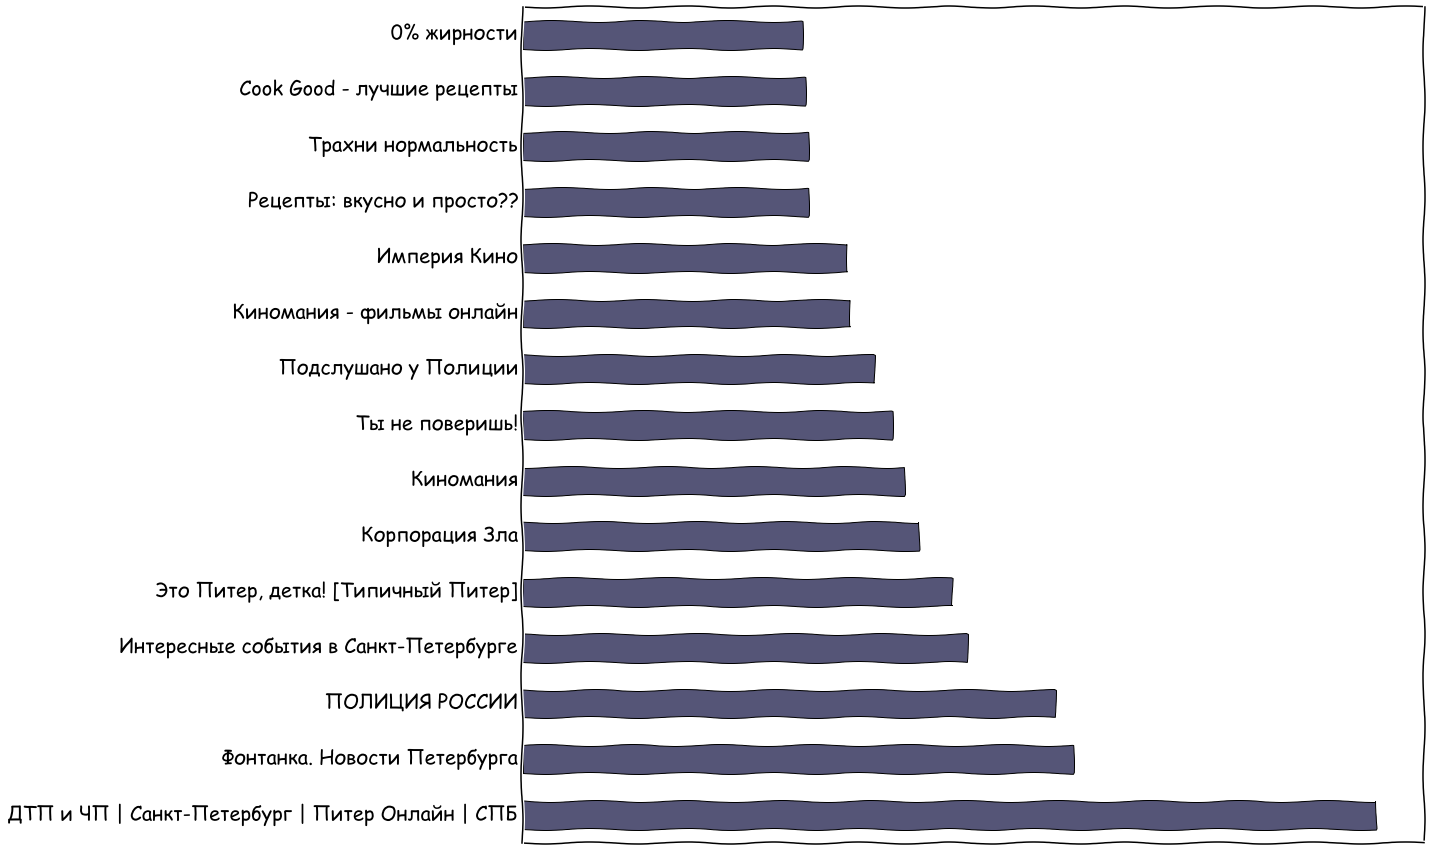

In [61]:
%matplotlib inline

def process_group_info(i):
    return {"name": i.get('name', ''),
            "count": i.get('people_count', 0)}

df = pd.DataFrame(map(process_group_info, groups_info[:15])).set_index('name')

matplotlib.rc('xtick', labelsize=0)
matplotlib.rc('ytick', labelsize=20)

p = df.plot(kind='barh', legend=False, color='#555577')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',
    bottom='off')         # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',
    right='off')         # labels along the bottom edge are off

p.set_ylabel("")
p.set_xlabel("")

p.get_figure().set_size_inches(20, 12)
p.get_figure().tight_layout()
p.get_figure().savefig('images/interests_police.png', dpi=100)